<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-2-Linear-Models/blob/master/module1/221A_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.2MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
#train/validate/test split with data

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
#Baseline for classification

train['status_group'].value_counts(normalize=True)

#Baseline is 54.3077% for functional, 38.4238% for non functional, and 07.2685% functional needs repair

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
train.head()

id  amount_tsh  ... waterpoint_type_group    status_group
43360  72938         0.0  ...    communal standpipe      functional
7263   65358       500.0  ...    communal standpipe      functional
2486     469        25.0  ...             hand pump      functional
313     1298         0.0  ...                 other  non functional
52726  27001         0.0  ...    communal standpipe      functional

[5 rows x 41 columns]

In [0]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [0]:
train[['longitude', 'latitude']].describe()

longitude      latitude
count  47520.000000  4.752000e+04
mean      34.082431 -5.705946e+00
std        6.552053  2.941332e+00
min        0.000000 -1.164944e+01
25%       33.092142 -8.528215e+00
50%       34.910740 -5.021436e+00
75%       37.170578 -3.327185e+00
max       40.344301 -2.000000e-08

In [0]:
#wrangle data to take care of errant values

import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
#rerun scatter plot

import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [0]:
##### AMAZING VIZ ######

# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [0]:
#further feature selection

# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 20
categorical_features = cardinality[cardinality <= 20].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(len(features))
print(features)

29
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
train_features.select_dtypes(exclude='number').nunique()

date_recorded              349
funder                    1716
installer                 1929
wpt_name                 30661
basin                        9
subvillage               17231
region                      21
lga                        124
ward                      2082
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2563
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
#put in the pipeline: for encoder for categorical, imputer for missing values, scaler, and regression
#also prints out validation adn verficiation accuracy which look good compared to baseline.
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred = pipeline.predict(X_test)

Training Accuracy 0.731986531986532
Validation Accuracy 0.7284511784511785


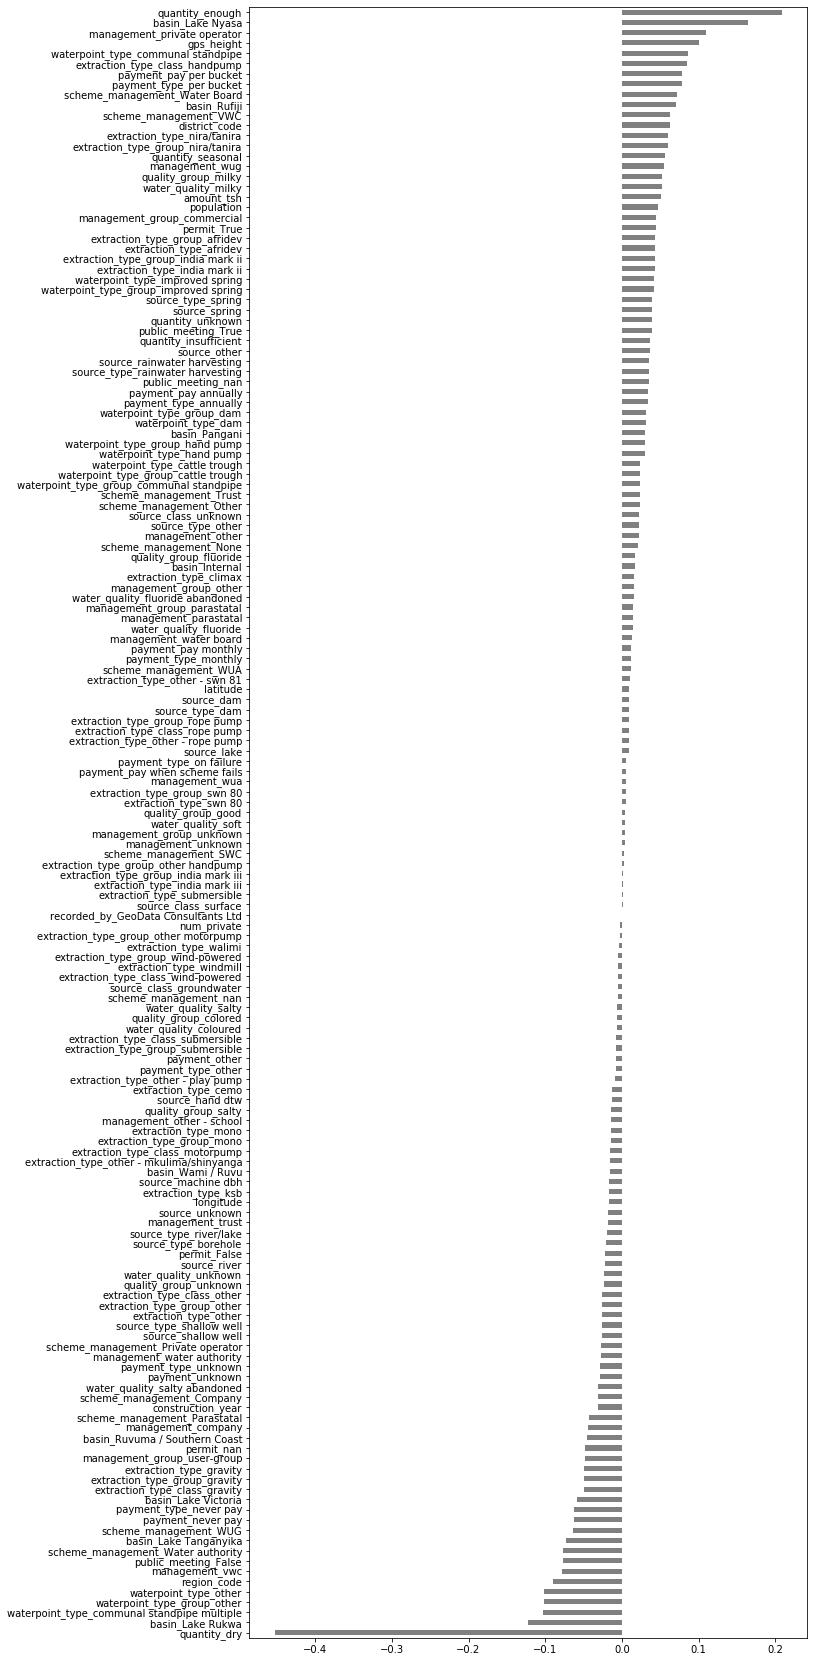

In [0]:
#plot for feature importance 

%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [0]:
#decision tree classifier
#gives us great train accuracy, and solid validation accuracy

from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred = pipeline.predict(X_test)

Training Accuracy 0.9954755892255892
Validation Accuracy 0.7585858585858586


In [0]:
#plot of decision tree

# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=True, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

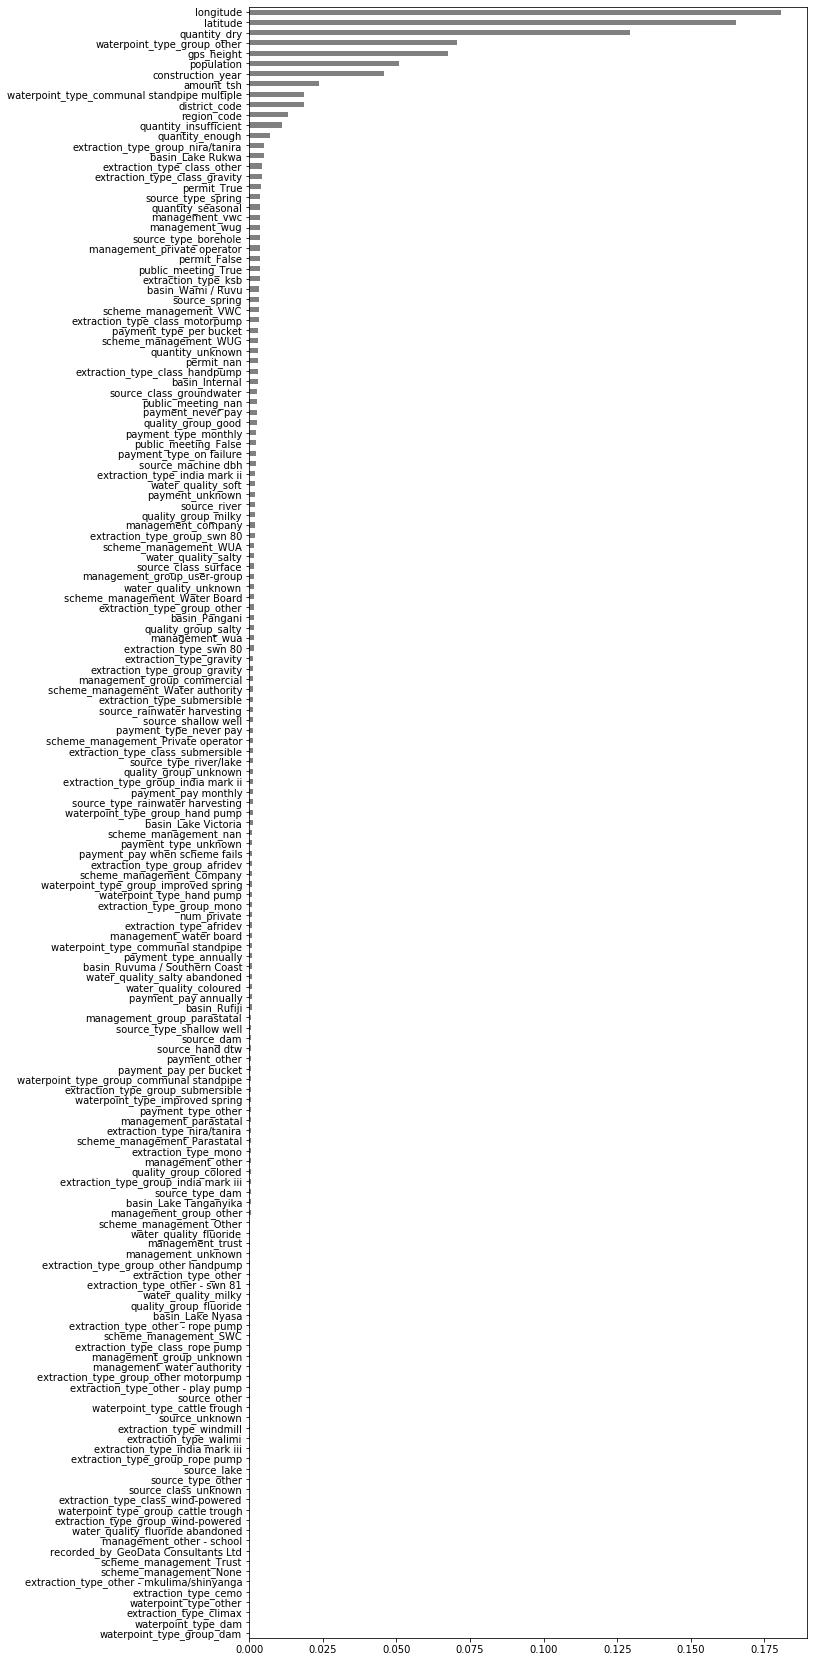

In [0]:
# Linear models have coefficients whereas decision trees have "Feature Importances"

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [0]:
y_pred = pipeline.predict(X_test)
sumbission = sample_submission.copy()
sumbission['status_group'] = y_pred
sumbission.to_csv('submission-03.csv', index=False)